# scikit-learn

## Overview

Scikit-learn [R] is a Python package containing a wide selection of tools for machine learning. Machine learning is a technique of using computers to make predtictions on unseen data based on either previously seen data or algorithms which find patterns within data. In addition to a large collection of data analysis algorithms, the package also provides tools for data preprocessing and dimensionality reduction; model selection and hyperparameter tuning - that is, finding an algorithm and a set of parameters to that algorithm that enable it to best perform on a particular dataset.


## Imports

The following code cells import all the libraries necessary to run this notebook. As there are alot of imports, they are divided into four cells according to their function for easier management. 

In [1]:
# General utilities

import os
import requests
from urllib.parse import urljoin

In [1]:
# Plotting libraries

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Data manipulation

import pandas as pd
import numpy as np

In [1]:
# scikit-learn

import sklearn.model_selection as mod
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

## The Wine Quality Dataset
The wine quality dataset, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/), consists of two semicolon-delimited files, one relating to Portuguese *Vinho Verde* red wines and one to whites. The datasets were produced by Cortez et al. [R] in order to assess various machine learning algorithms in prediction of the quality of a wine from its properties. They considered support vector machines, multiple regression analysis, and neural networks. Of these the best performance was achieved using SVM [RPaper,RDatasheet].

Twelve attributes are recorded for each wine sample; eleven are objective physical or chemical attributes, and one, `quality`, is a subjective assessment of the wine's quality. The `quality` attribute is recorded as a value from 0 (poorest quality) to 10 (best quality) and is derived from the median score assigned to it by at least three experts [RDatasheet].

The data information sheet distributed with the data [R] notes that several attributes may be correlated and that not all attributes necessarily affect quality and suggests that feature selection may be advisable. The datasheet also suggests that the problem of wine quality prediction may be cast as a regression problem or as a classification problem.


### Steps

1. [Acquire the data](#Acquire-the-dataset)
1. Explore the data
    1. View
    1. View distributions of features
    1. View correlations between features
    1. Assess relative influence of each feature on the target variable
    1. View distribution of target variable
1. Feature selection or dimensionality reduction
    1. Consider whether feature selection or dimensionality reduction are appropriate
    1. Remove features if desired using information discovered during data exploration
    1. Keeping full dataset with all features, generate subsets using desired combinations of features
    1. Generate subsets using considered dimensionality reduction techniques with various parameters if appropriate
1. Normalisation and Standardisation
    1. Consider whether any or all of the features should be normalised or standardised in some way
    1. Generate adjusted subsets for each of the subsets generated above
1. Model selection
    1. Decide on whether the problem will be cast as binary classification, multiclass classification, or regression
    1. Adjust target variable as necessary
    1. Select some suitable models
1. Hyperparameter tuning
    1. Construct a grid search or randomized search to test various combinations of hyperparameters
1. Fit and assess models
    1. Fit each model/hyperparameter/featureset combination
    1. Conduct assessment appropriate to each combination
    1. Select best candidates and fine tune
1. Test predictions
    1. Use trained model(s) to predict test set
    2. Assess model performance on test set


### Acquire the dataset
The dataset is downloaded as two semicolon delimited files from the UCI Machine Learning Repository and saved to disc.

In [2]:
# Location of wine quality dataset
base_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'
# Local data directory
data_dir = 'data/wine/'

# Names of dataset files to be downloaded
source_files = ('winequality-red.csv', 'winequality-white.csv', 'winequality.names')

# for each of the source files construct url, 
# fetch file, and write to data directory
for datafile in (source_files):
    response = requests.get(urljoin(base_url, datafile))
    with open(os.path.join(data_dir, datafile), 'wb') as f:
        f.write(response.content)

In [3]:
# Load red wine and white wine datasets into pandas DataFrames
rw = pd.read_csv('data/wine/winequality-red.csv', delimiter=";")
ww = pd.read_csv('data/wine/winequality-white.csv', delimiter=";")

## Exploring the dataset and selecting features

In [4]:
# See the first few records of the red wine dataset
rw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


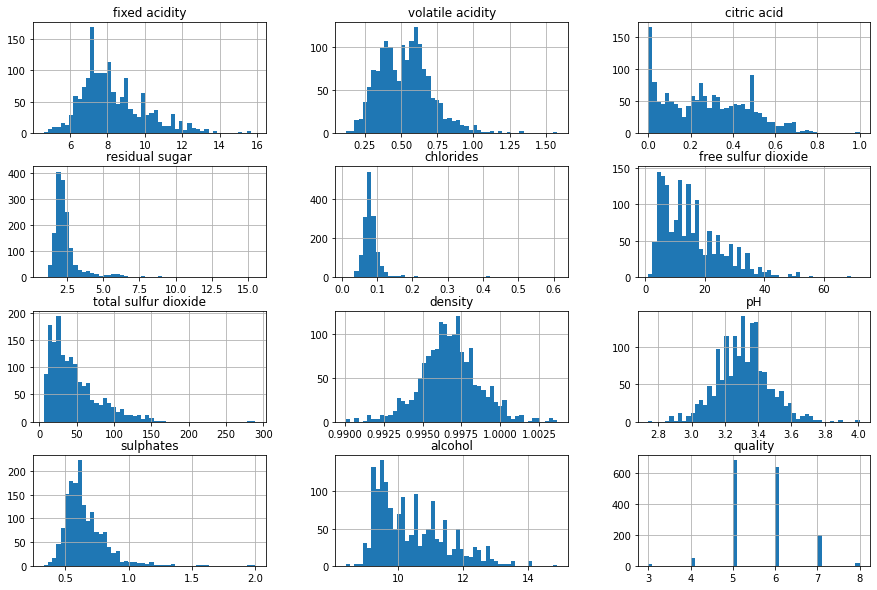

In [5]:
# View a histogram of each feature
hist = rw.hist(bins=50, figsize=(15, 10))
plt.show()

In [6]:
rw['quality_cat'] = np.where(rw['quality'] <= 4, 'low', np.where(rw['quality'] >= 7, 'high', 'medium'))

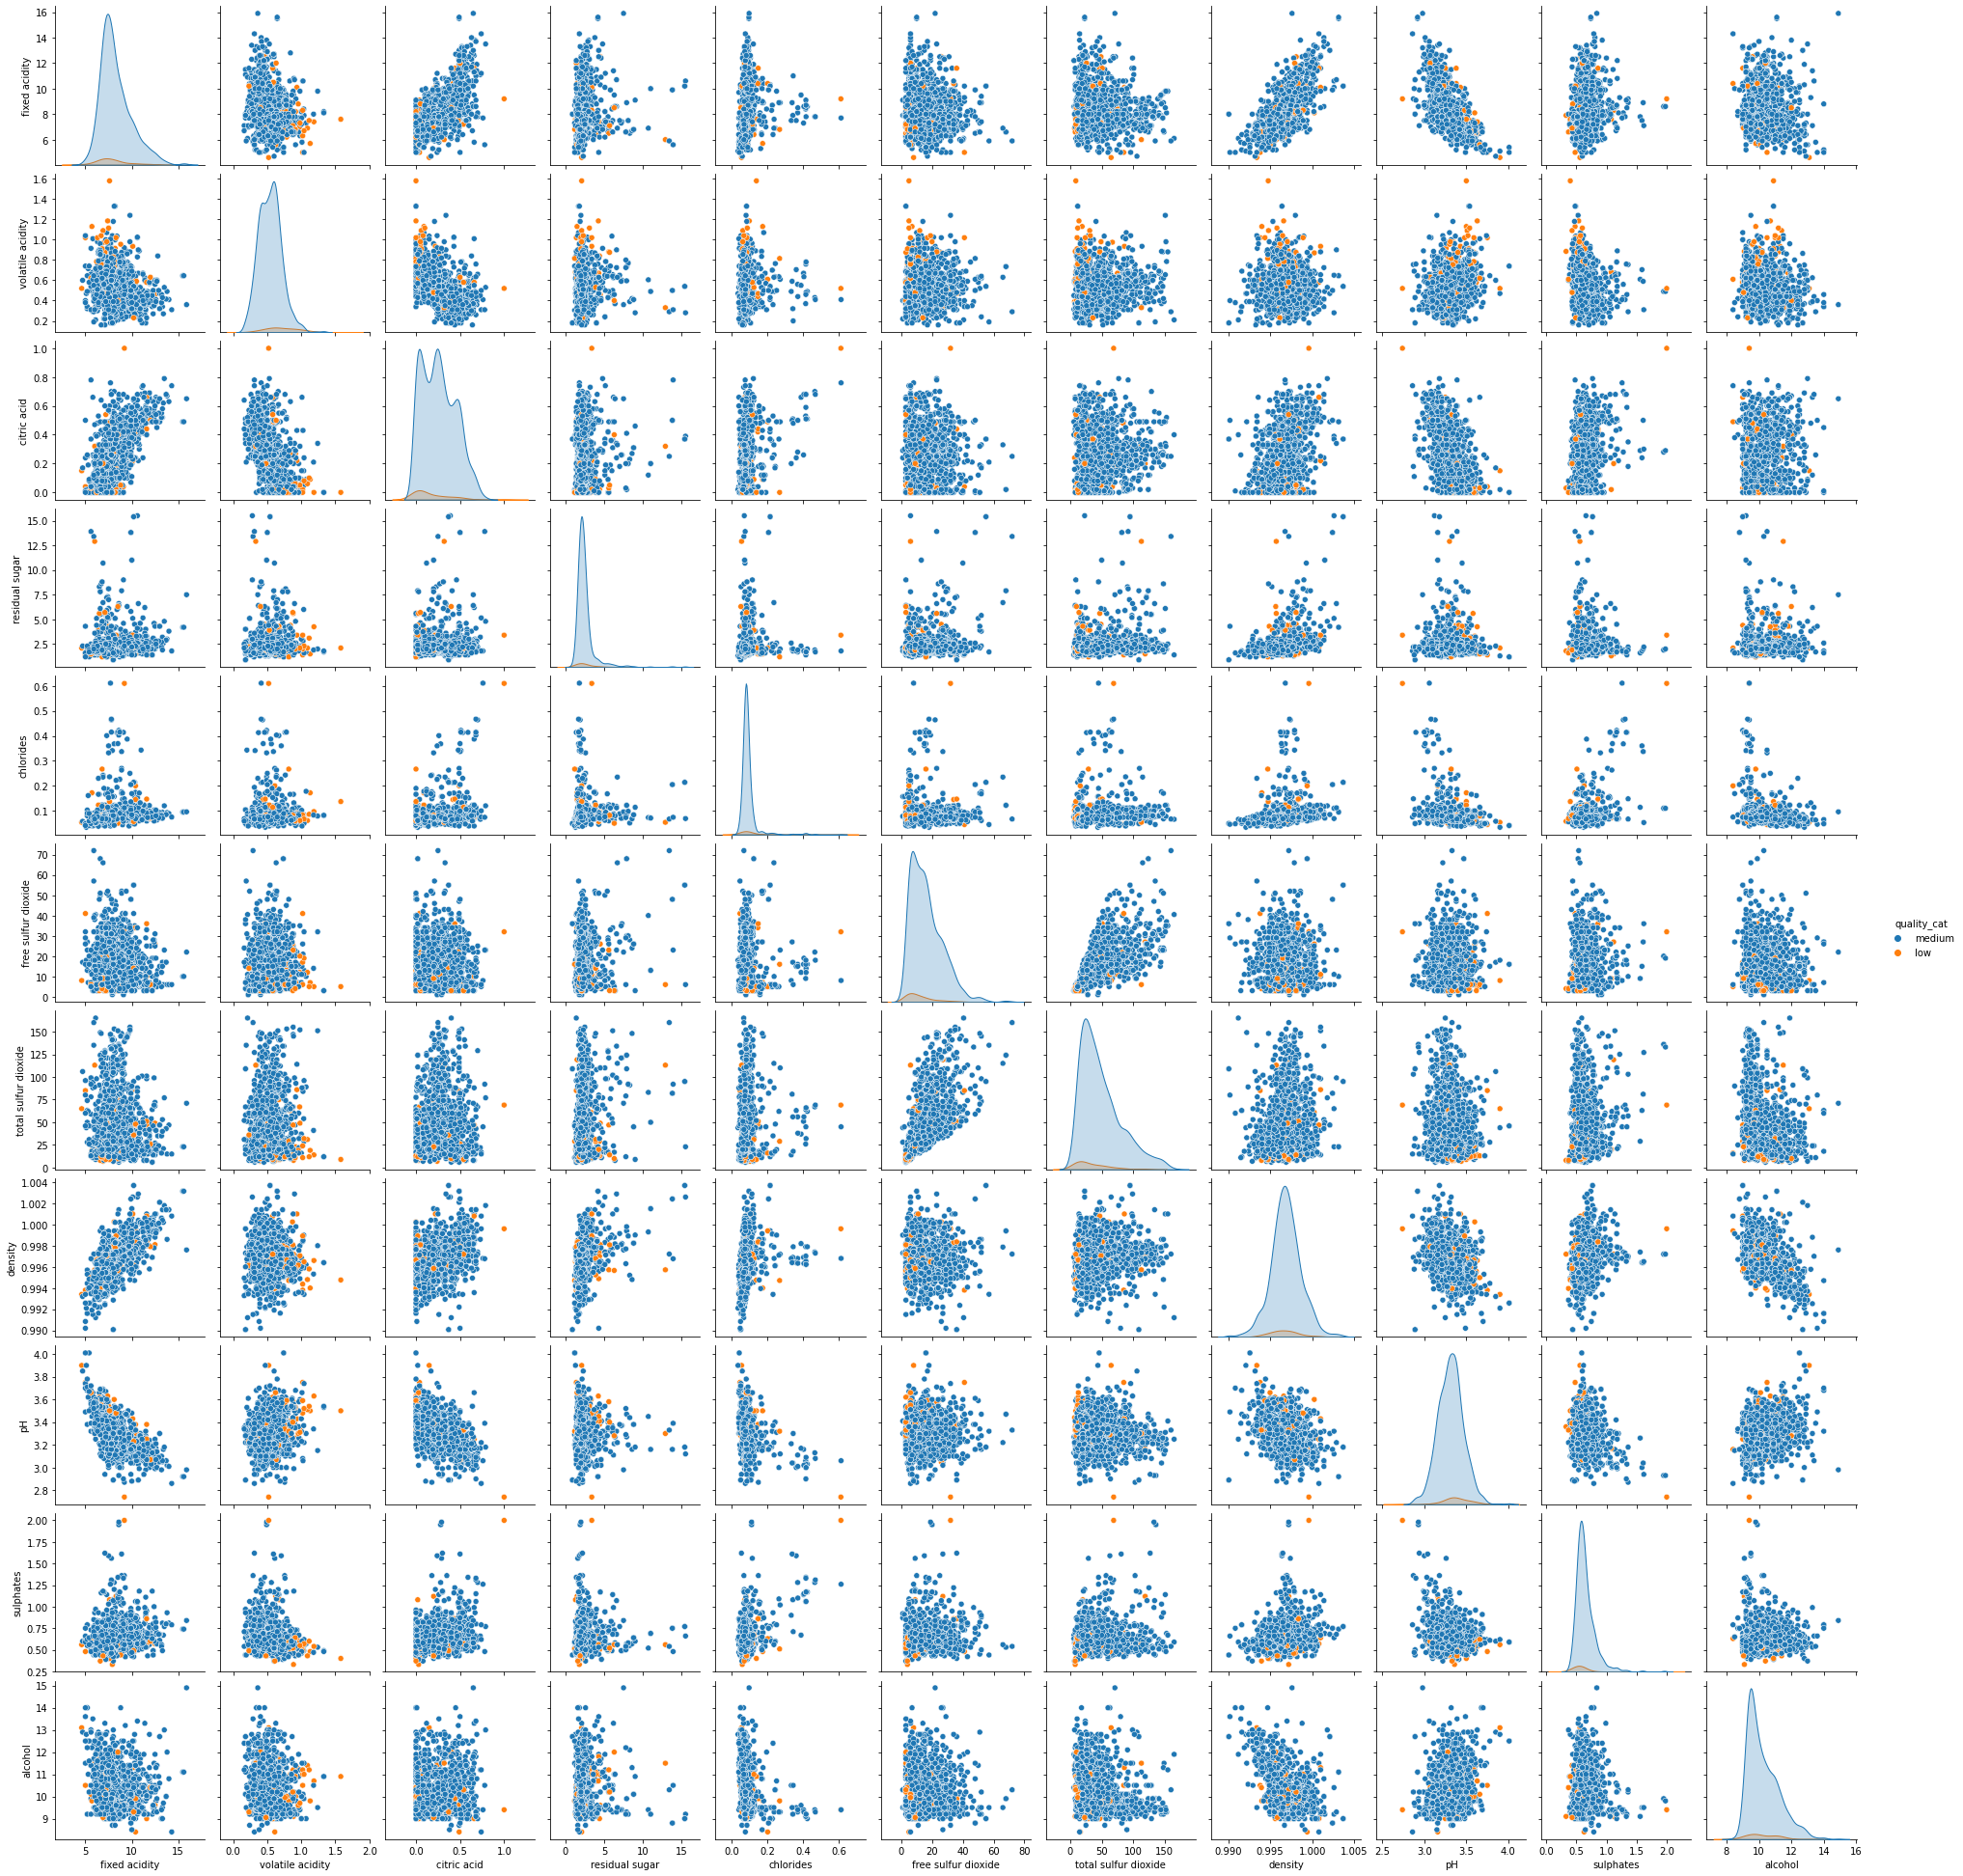

In [7]:
sns.pairplot(rw[rw['quality_cat'].isin(['medium','low'])].drop('quality', axis=1), hue='quality_cat')

In [8]:
#rw=rw.drop(['quality_cat'], axis=1)

In [9]:
corr = rw.corr()
abs(corr).min().min()


0.0019178819627909175

In [10]:
#np.fill_diagonal(corr.values,0)

<AxesSubplot:>

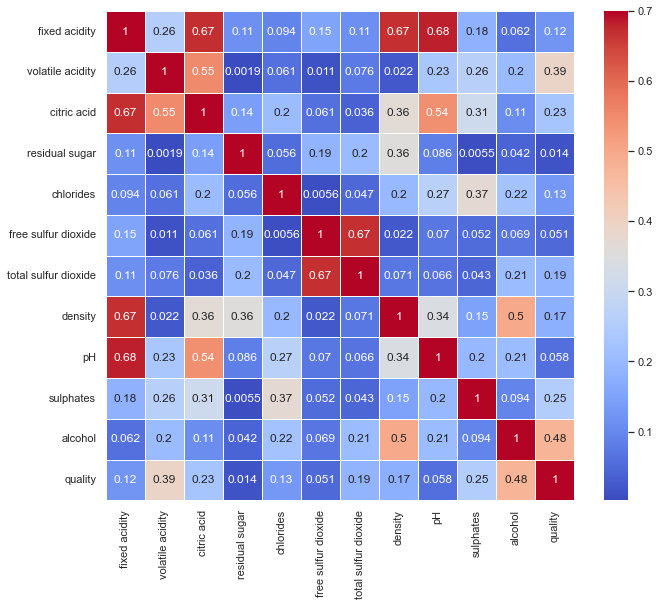

In [43]:
sns.set(rc={'figure.figsize':(10.5,9)})
sns.heatmap(abs(corr), annot=True, linewidths=0.5, cmap='coolwarm', vmax=0.7)

`Fixed acidity` is correlated with `citric acid`, `density`, and `pH`
`citric acid` also has a fairly strong correlation with `volatile acidity` and `pH`
`density` has a correlation of 0.5 with `alcohol`
`total sulfur dioxide` and `free sulfur dioxide` are highly correlated
It seems that perhaps `citric acid`, `density`, `pH`, and `free sulfur dioxide` could be dropped.

Correlation with `quality` shows which attributes have the strongest influence on the output variable. It would be instructive to examine that individually. First we look at the features we propose to keep:

In [12]:
# Sort values in the correlation matrix by the absolute correlation value
abs(corr['quality'].drop(['quality', 'citric acid', 'density', 'pH', 'free sulfur dioxide'])).sort_values(ascending=False)

alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
total sulfur dioxide    0.185100
chlorides               0.128907
fixed acidity           0.124052
residual sugar          0.013732
Name: quality, dtype: float64

`residual sugar` seems to have a negligible influence on quality. We'll try dropping that too for now.

In [13]:
# Double check correlations between dropped features and quality
abs(corr['quality'].drop(['quality', 'alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'chlorides', 'fixed acidity', 'residual sugar'])).sort_values(ascending=False)

citric acid            0.226373
density                0.174919
pH                     0.057731
free sulfur dioxide    0.050656
Name: quality, dtype: float64

In [14]:
# Drop some features
rwd = rw.drop(['citric acid', 'density', 'pH', 'free sulfur dioxide', 'residual sugar'], axis=1)

In [15]:
rwd.head()

,fixed acidity,volatile acidity,chlorides,total sulfur dioxide,sulphates,alcohol,quality,quality_cat
0,7.4,0.70,0.076,34.0,0.56,9.4,5,medium
1,7.8,0.88,0.098,67.0,0.68,9.8,5,medium
2,7.8,0.76,0.092,54.0,0.65,9.8,5,medium
3,11.2,0.28,0.075,60.0,0.58,9.8,6,medium
4,7.4,0.70,0.076,34.0,0.56,9.4,5,medium


## Preprocessing the data


In [16]:
train, test = mod.train_test_split(rwd.drop(['quality'], axis=1))

In [17]:
X, y = train.drop(['quality_cat'], axis=1), train['quality_cat']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test.drop(['quality_cat'], axis=1)) 
model = SVC(kernel="poly", degree=3, coef0=1, C=5)
# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
# ])

model.fit(X_scaled,y)

SVC(C=5, coef0=1, kernel='poly')

In [18]:
model.score(X_test_scaled, test['quality_cat'])

0.8025

### Cross validation

In [19]:
scores = cross_val_score(model, X_scaled, y, cv=10)
print(scores, '\n', scores.mean(), '\n', scores.std())

[0.86666667 0.86666667 0.88333333 0.825      0.86666667 0.81666667
 0.85       0.84166667 0.875      0.8487395 ] 
 0.8540406162464986 
 0.020526380767996524


### Stratified shuffle split

In [20]:
rwdd =rwd.drop(['quality'], axis=1)

In [21]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
X, y = rwdd.drop(['quality_cat'], axis=1), rwdd['quality_cat']
for train_idx, test_idx in sss.split(rwdd.drop(['quality_cat'], axis=1), rwdd['quality_cat']):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx] 
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]


In [76]:
# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
# ])
svm_clf = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5))
svm_clf.fit(X_train, y_train)

{'C': 5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 1, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

In [23]:
svm_clf.score(X_test, y_test)

0.853125

In [24]:
scores = cross_val_score(svm_clf, X, y, cv=10)
print(scores, '\n', scores.mean(), '\n', scores.std())

[0.80625   0.83125   0.81875   0.81875   0.83125   0.8625    0.83125
 0.86875   0.8125    0.8427673] 
 0.8324017295597486 
 0.019471153761633782


In [25]:
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=5)

In [26]:
cm = confusion_matrix(y_train, y_train_pred, labels=['low', 'medium', 'high'])

<Figure size 216x144 with 0 Axes>

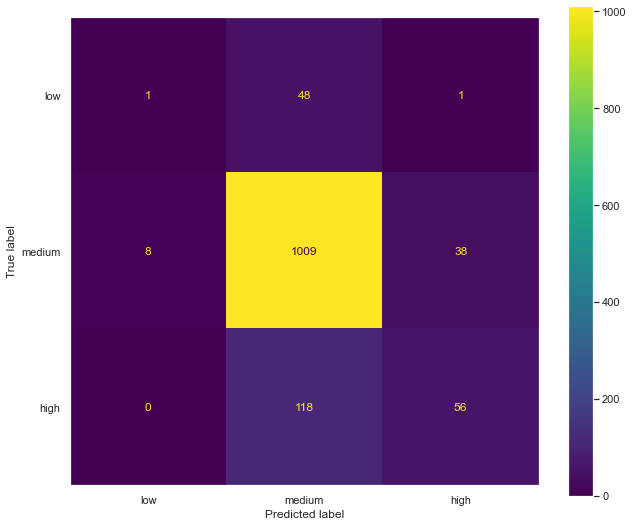

In [53]:
plt.figure(figsize=(3,2))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, labels=['low', 'medium', 'high'])
plt.grid(False)
plt.show()


In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score
avg = 'weighted'
for score in (precision_score, recall_score, f1_score):
    print(f"{score.__name__}: {score(y_train, y_train_pred, average=avg)}")
          
          
precision = precision_score(y_train, y_train_pred, average=avg)
recall = recall_score(y_train, y_train_pred, average=avg)
f1 = f1_score(y_train, y_train_pred, average=avg)
print(precision, recall, f1)

precision_score: 0.7928672150879975
recall_score: 0.8334636434714621
f1_score: 0.8044136417380391
0.7928672150879975 0.8334636434714621 0.8044136417380391


### All medium classifier

In [28]:
class alwaysMedium(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return(['medium'] * len(X))

In [73]:
model = alwaysMedium()
scores = cross_val_score(model, X, y, cv=10, scoring="accuracy")
print(scores, '\n', scores.mean(), '\n', scores.std())

{}
[0.9125     0.84375    0.8        0.825      0.9375     0.675
 0.71875    0.7875     0.9125     0.83647799] 
 0.8248977987421384 
 0.08016998487231636


In [30]:
# See the first few records of the white wine dataset
ww.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [31]:
rw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [32]:
ww.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


## References

[1] Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J., 2009, Modeling wine preferences by data mining from physicochemical properties, Decision Support Systems 47(4):547-553. doi:10.1016/j.dss.2009.05.016 

[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

[3] Scikit-learn developers, https://scikit-learn.org/stable/modules/preprocessing.html
